In [0]:
# Load necessary packages
import numpy as np
import pandas as pd
import matplotlib as mpl
from plotnine import *

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data-processing modules 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modeling and evaluation modules 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Module for saving model
import pickle 

# Set seed for reproducibility 
SEED = 42

In [2]:
# Set up shared drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load dataset 
datapath = '/content/drive/Shared drives/Machine Learning/Code/data/financial_data.csv'
data = pd.read_csv(datapath)

In [0]:
# Renaming columns for consistency
data = data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                            'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [5]:
# Create new feature to document account type 
data["accountType"] = np.nan 
data.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"accountType"] = "CC" 
data.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('M'),"accountType"] = "CM"
data.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('C'),"accountType"] = "MC"
data.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('M'),"accountType"] = "MM"
data.accountType.value_counts()

CC    4211125
CM    2151495
Name: accountType, dtype: int64

In [0]:
# Create 2 new features
# errorBalanceOrig: error amount of the transaction leaving the original account
# errorBalanceDest: error amount of the transaction arriving the destination account
data["errorBalanceOrig"] = data.newBalanceOrig + data.amount - data.oldBalanceOrig
data["errorBalanceDest"] = data.oldBalanceDest + data.amount - data.newBalanceDest

In [0]:
# Create new feature to document day (of the 1-month simulation)
data['day'] = data['step'].map(lambda x: x//24)

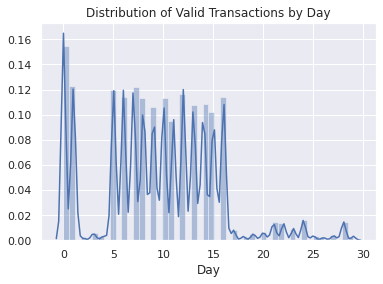

In [8]:
# Distribution of valid transactions by day 
sns.distplot(data.loc[data.isFraud == 0].day)
plt.xlabel('Day')
plt.title('Distribution of Valid Transactions by Day')
plt.show()

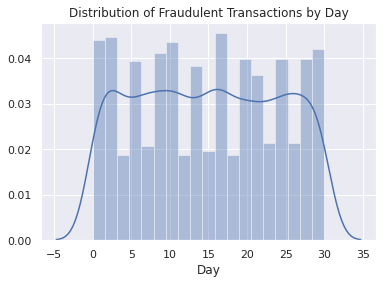

In [9]:
# Distribution of fraudulent transactions by day 
sns.distplot(data.loc[data.isFraud == 1].day)
plt.xlabel('Day')
plt.title('Distribution of Fraudulent Transactions by Day')
plt.show()

One-Hot Encoding

In [0]:
# Get dummies of transaction type 
types = pd.get_dummies(data.type)
data = data.join(types)

In [0]:
# Get dummies of account type 
accountTypes = pd.get_dummies(data.accountType)
data = data.join(accountTypes)

In [0]:
# Separate amount into quartiles and get dummies 
data['amountQuartiles'] = pd.qcut(data.amount, 4, labels=["quartile1", "quartile2", "quartile3","quartile4"])
quartiles = pd.get_dummies(data.amountQuartiles)
data = data.join(quartiles)

Fraud Count by Transaction Amount

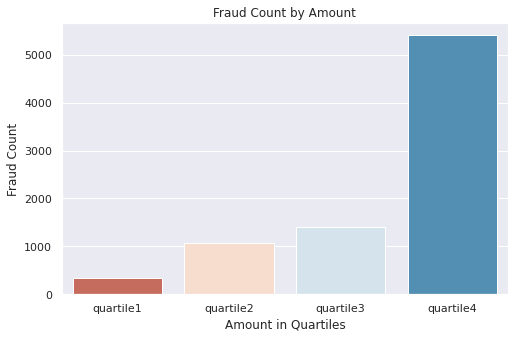

In [0]:
fraud_by_amount = data.loc[data.isFraud == 1].groupby('amountQuartiles').size().reset_index(name="fa_count")\
    .sort_values("fa_count", ascending = False)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="amountQuartiles", y="fa_count", data=fraud_by_amount,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Amount in Quartiles", ylabel="Fraud Count", 
           title = 'Fraud Count by Amount')

In [0]:
# Get dimension after feature engineering  
data.shape 

(6362620, 27)

Features to Drop

In [0]:
data.drop(['type','nameOrig','nameDest','isFlaggedFraud','amountQuartiles','accountType'],axis = 1,inplace = True)
data.shape

(6362620, 21)

Saving Dataset after Feature Engineering

In [0]:
# Save the transformed dataset
data.to_csv('/content/drive/Shared drives/Machine Learning/Code/df_new.csv')

Understanding Feature Correlation

In [0]:
# Understanding correlation between each feature and the target variable 
feature_corr=data.corr()
feature_corr["isFraud"].sort_values(ascending=False)

isFraud             1.000000
amount              0.076688
errorBalanceDest    0.055120
TRANSFER            0.053869
quartile4           0.033873
day                 0.032577
step                0.031578
CC                  0.025697
CASH_OUT            0.011256
oldBalanceOrig      0.010154
newBalanceDest      0.000535
DEBIT              -0.002911
oldBalanceDest     -0.005885
quartile3          -0.006573
newBalanceOrig     -0.008148
quartile2          -0.009920
errorBalanceOrig   -0.011283
quartile1          -0.017380
CASH_IN            -0.019089
PAYMENT            -0.025697
CM                 -0.025697
Name: isFraud, dtype: float64

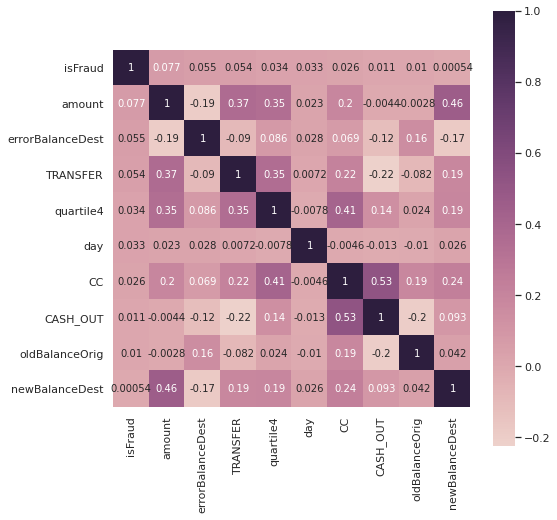

In [0]:
# Draw a correlation matrix of target variable "isFraud" and 10 features with highest correlation
corr_cols = ['isFraud','amount','errorBalanceDest','TRANSFER','quartile4','day','CC','CASH_OUT','oldBalanceOrig','newBalanceDest']

plt.figure(figsize=(8, 8))

corr = data[corr_cols].corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap=sns.cubehelix_palette(as_cmap=True),
            square = True, annot = True)

plt.show()